In [12]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler


In [13]:
# Path to CSV file
file_path = 'Mushrooms.data.csv'

# Column names of dataset 
column_names = [
    'poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Load the dataset
df = pd.read_csv(file_path, sep=',', names=column_names, header=None)

# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head()

# Check if there are any missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Save the dataframe for the next steps
df.to_csv('explored_mushrooms.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8125 entries, 0 to 8124
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8125 non-null   object
 1   cap-shape                 8125 non-null   object
 2   cap-surface               8125 non-null   object
 3   cap-color                 8125 non-null   object
 4   bruises                   8125 non-null   object
 5   odor                      8125 non-null   object
 6   gill-attachment           8125 non-null   object
 7   gill-spacing              8125 non-null   object
 8   gill-size                 8125 non-null   object
 9   gill-color                8125 non-null   object
 10  stalk-shape               8125 non-null   object
 11  stalk-root                8125 non-null   object
 12  stalk-surface-above-ring  8125 non-null   object
 13  stalk-surface-below-ring  8125 non-null   object
 14  stalk-color-above-ring  

In [14]:
# Load the dataset
df = pd.read_csv('explored_mushrooms.csv')

# Clean and preprocess the data
df['poisonous'] = df['poisonous'].replace({'poisonous': 'p', 'edible': 'e'})
df['poisonous'] = df['poisonous'].map({'p': 1, 'e': 0})

# Handle missing values by filling with mode
df = df.apply(lambda col: col.fillna(col.mode()[0]))

# Save the cleaned dataframe
df.to_csv('cleaned_mushrooms.csv', index=False)


# Class Distribution Visualization

In this section, we will visualize the distribution of the target variable (poisonous vs. edible). This will give us an understanding of the class imbalance in the dataset.


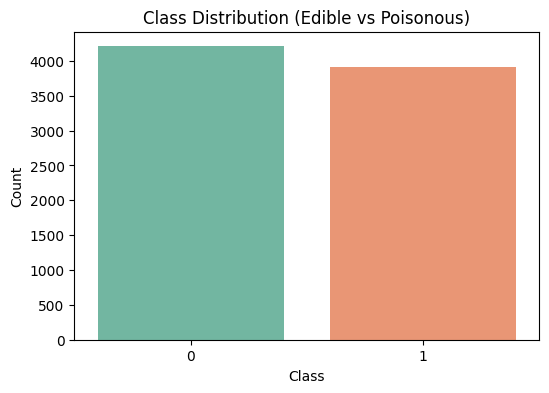

In [15]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_mushrooms.csv')

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='poisonous', data=df, hue='poisonous', palette="Set2", legend=False)
plt.title('Class Distribution (Edible vs Poisonous)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



# Categorical Feature Distribution Visualization

We will now plot the distribution of several categorical features to explore how they vary with the target variable.


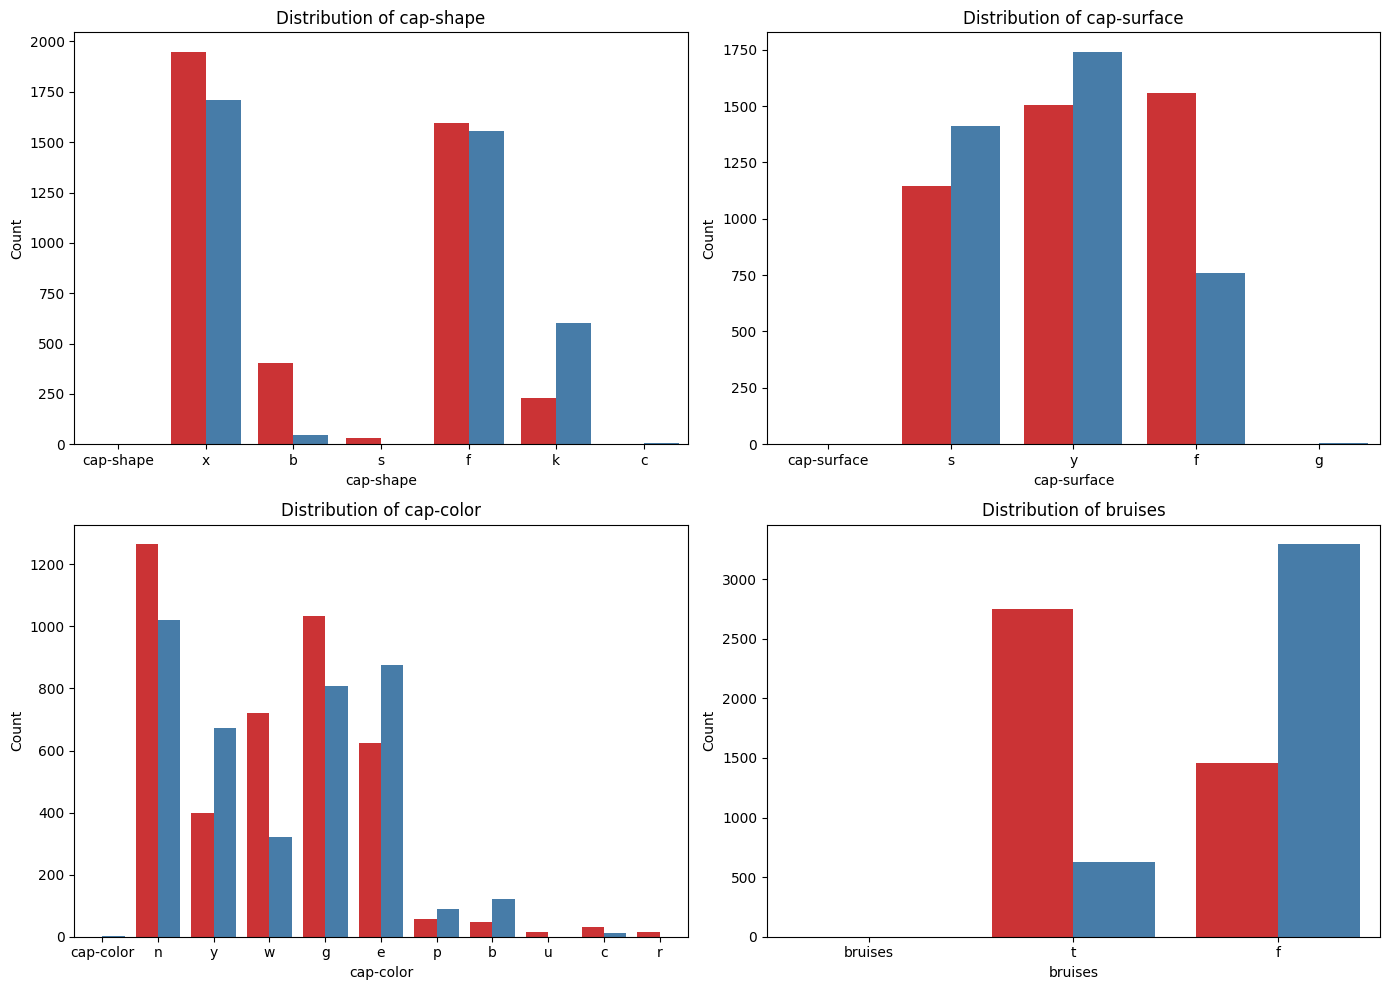

In [16]:
# Plot the distribution of the first few categorical features
plt.figure(figsize=(14, 10))
for i, column in enumerate(df.columns[1:5]):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=column, data=df, hue='poisonous', palette="Set1", legend=False)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Feature Correlation Visualization

We will compute the point-biserial correlation for each feature with the target variable (poisonous vs. edible) and visualize the top 10 correlated features. This will help us understand which features are most strongly associated with the target variable.


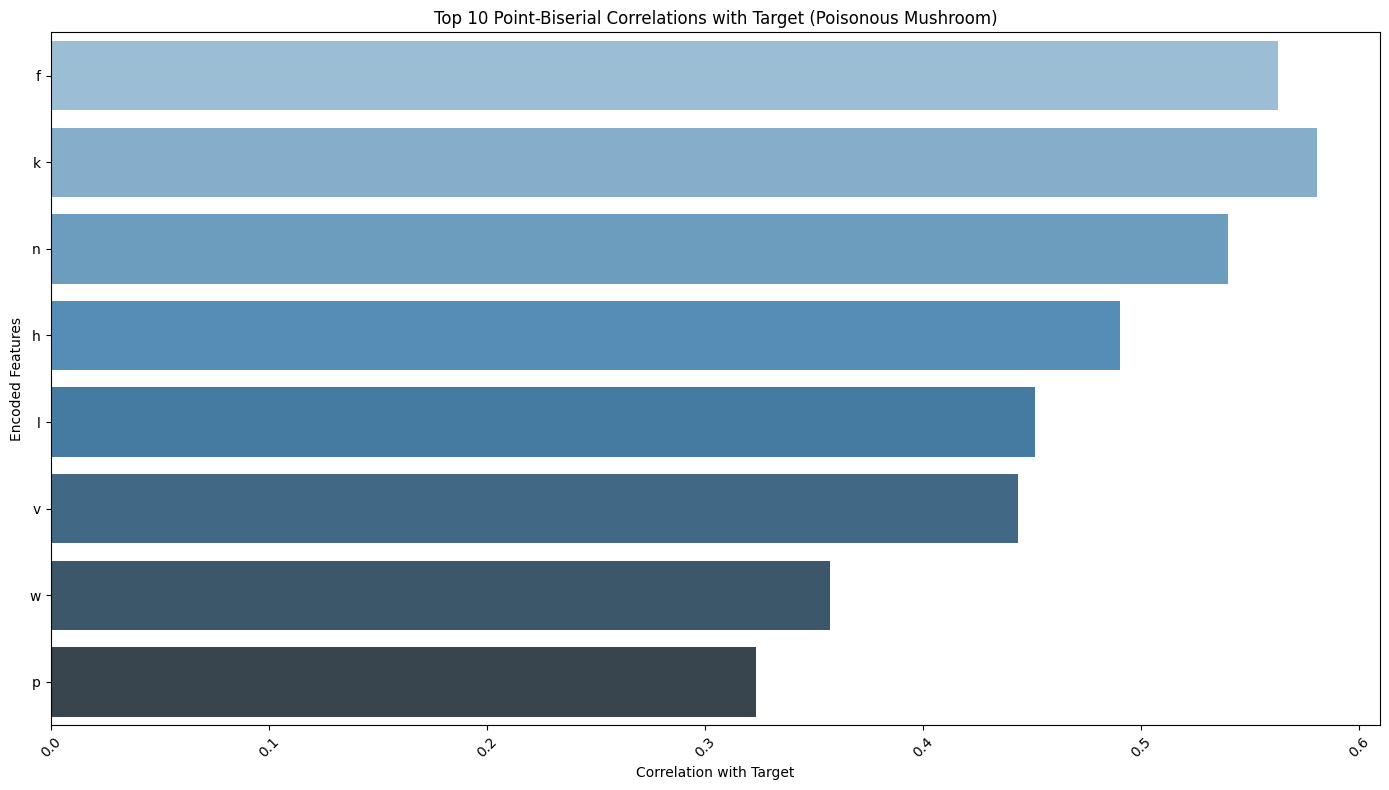

In [17]:
# Load cleaned data
df = pd.read_csv('cleaned_mushrooms.csv')

# Calculate point-biserial correlation for each feature
correlations = []
for column in df.columns[1:]:  
    feature = pd.get_dummies(df[column], drop_first=True) 
    for col in feature.columns:
        corr, _ = pointbiserialr(df['poisonous'], feature[col])
        correlations.append((column, col, corr))

corr_df = pd.DataFrame(correlations, columns=['Feature', 'Encoded Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Save top correlated features
top_corr_df = corr_df.head(10)
top_corr_df.to_csv('top_correlated_features.csv', index=False)

# Plot top correlated features
plt.figure(figsize=(14, 8)) 
sns.barplot(x='Correlation', y='Encoded Feature', data=top_corr_df, hue='Encoded Feature', palette='Blues_d', dodge=False, errorbar=None, legend=False)
plt.title('Top 10 Point-Biserial Correlations with Target (Poisonous Mushroom)')
plt.xlabel('Correlation with Target')
plt.ylabel('Encoded Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Load cleaned data
df = pd.read_csv('cleaned_mushrooms.csv')

# Convert categorical features to one-hot encoded variables
y = df['poisonous']
X = pd.get_dummies(df.drop('poisonous', axis=1), drop_first=True)

# Convert any boolean columns to integers
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Verify the encoding
print(X.dtypes)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Continue with feature selection and splitting the dataset
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_resampled, y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

# Save train/test data
pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)


cap-shape_c            int64
cap-shape_cap-shape    int64
cap-shape_f            int64
cap-shape_k            int64
cap-shape_s            int64
                       ...  
habitat_l              int64
habitat_m              int64
habitat_p              int64
habitat_u              int64
habitat_w              int64
Length: 117, dtype: object


In [19]:
# Load train/test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Reduce the size of the training data
X_train_reduced = X_train[:3000]
y_train_reduced = y_train[:3000]

# Standardize the data
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test = scaler.transform(X_test)

# Initialize the SVM model with adjusted parameters
initial_svm_model_adjusted = SVC(kernel='sigmoid', C=50, gamma='auto', random_state=42)

# Perform cross-validation
cv_scores_adjusted = cross_val_score(initial_svm_model_adjusted, X_train_reduced, y_train_reduced, cv=5)
print(f"Cross-validation scores (Adjusted Model): {cv_scores_adjusted}")
print(f"Average cross-validation score (Adjusted Model): {np.mean(cv_scores_adjusted)}")

# Train the initial model with adjustments
initial_svm_model_adjusted.fit(X_train_reduced, y_train_reduced)

# Make predictions with the initial model with adjustments
y_pred_initial_adjusted = initial_svm_model_adjusted.predict(X_test)

# Evaluate the initial model with adjustments
print("Initial Model (Adjusted) - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_initial_adjusted))
print("\nInitial Model (Adjusted) - Classification Report:")
print(classification_report(y_test, y_pred_initial_adjusted))
print("\nInitial Model (Adjusted) - Accuracy Score:")
print(accuracy_score(y_test, y_pred_initial_adjusted))

Cross-validation scores (Adjusted Model): [0.97       0.955      0.94333333 0.96166667 0.96      ]
Average cross-validation score (Adjusted Model): 0.958
Initial Model (Adjusted) - Confusion Matrix:
[[791  52]
 [ 19 822]]

Initial Model (Adjusted) - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       843
           1       0.94      0.98      0.96       841

    accuracy                           0.96      1684
   macro avg       0.96      0.96      0.96      1684
weighted avg       0.96      0.96      0.96      1684


Initial Model (Adjusted) - Accuracy Score:
0.9578384798099763


In [20]:
# Load train/test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the SVM model
svm_model = SVC(kernel='linear', C=0.1, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {np.mean(cv_scores)}")

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Cross-validation scores: [0.97550111 0.97253155 0.98142645 0.97994056 0.97399703]
Average cross-validation score: 0.976679341357328
Confusion Matrix:
[[823  20]
 [ 14 827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       843
           1       0.98      0.98      0.98       841

    accuracy                           0.98      1684
   macro avg       0.98      0.98      0.98      1684
weighted avg       0.98      0.98      0.98      1684


Accuracy Score:
0.9798099762470309
